<a href="https://colab.research.google.com/github/AstroAadhav/VASCode/blob/main/REPIIPROJII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

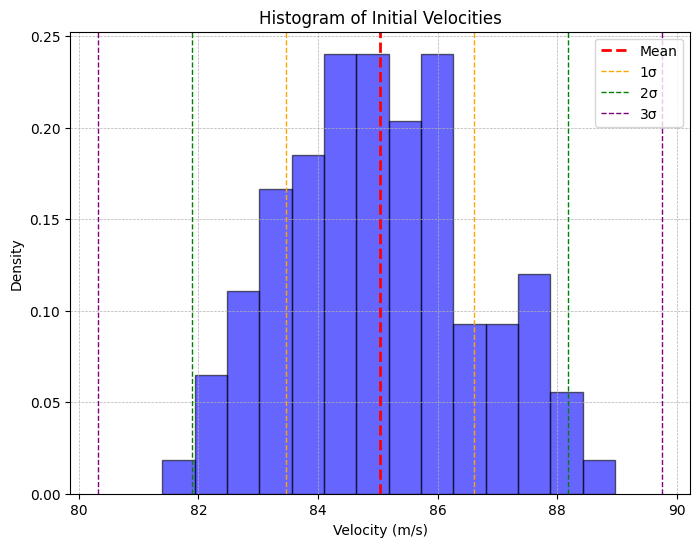

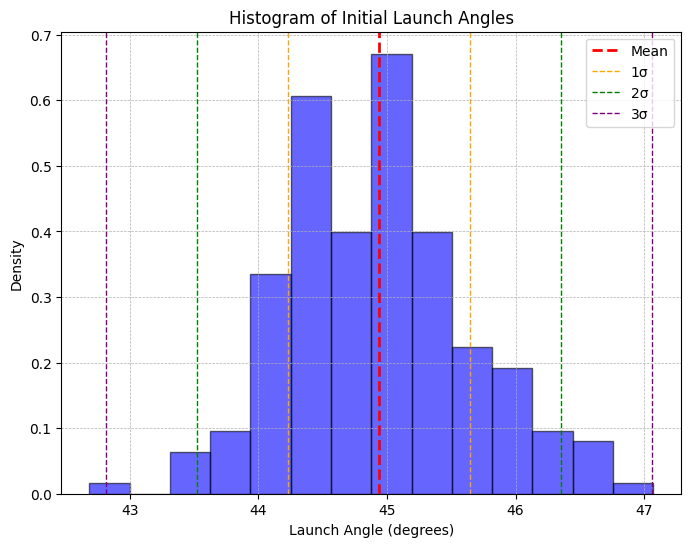

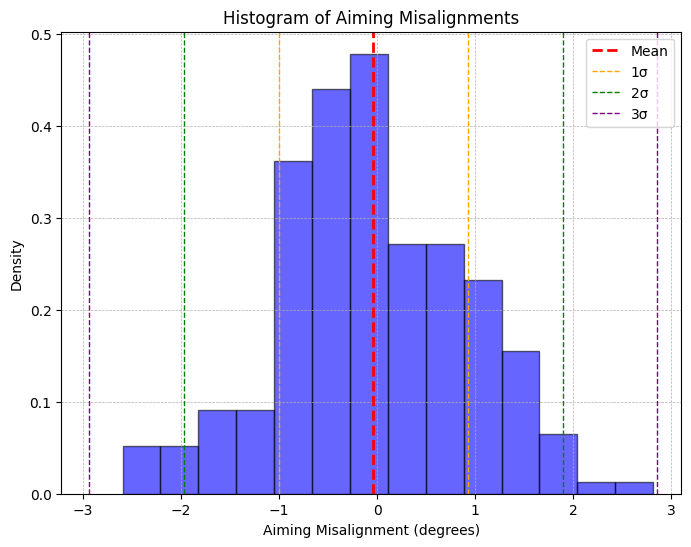

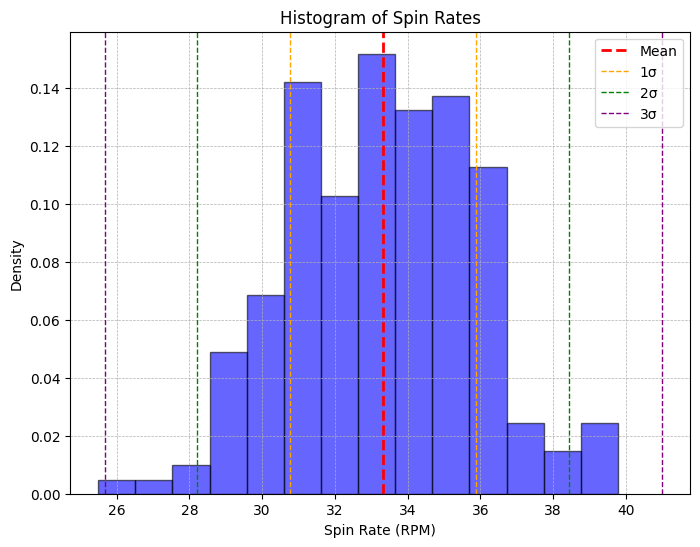

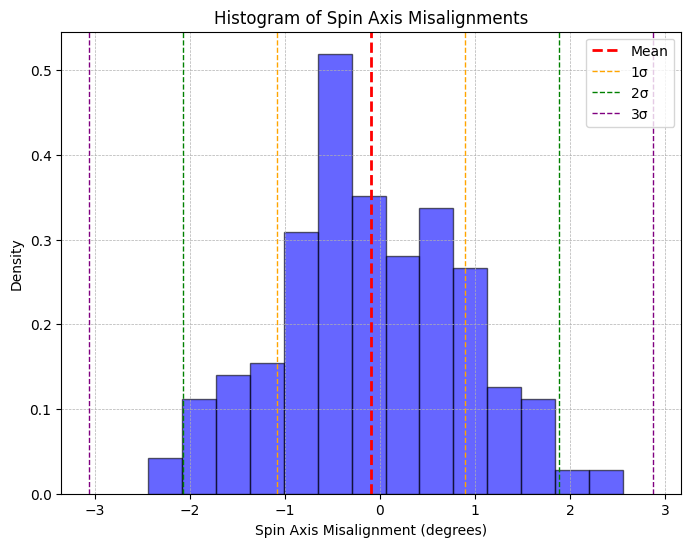

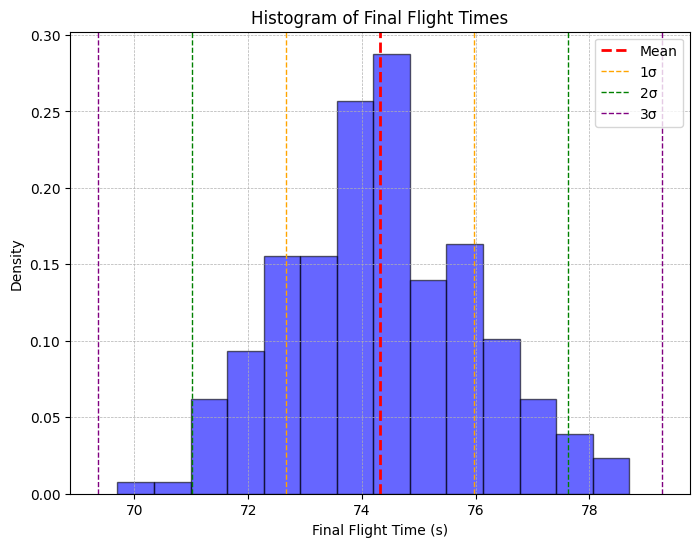

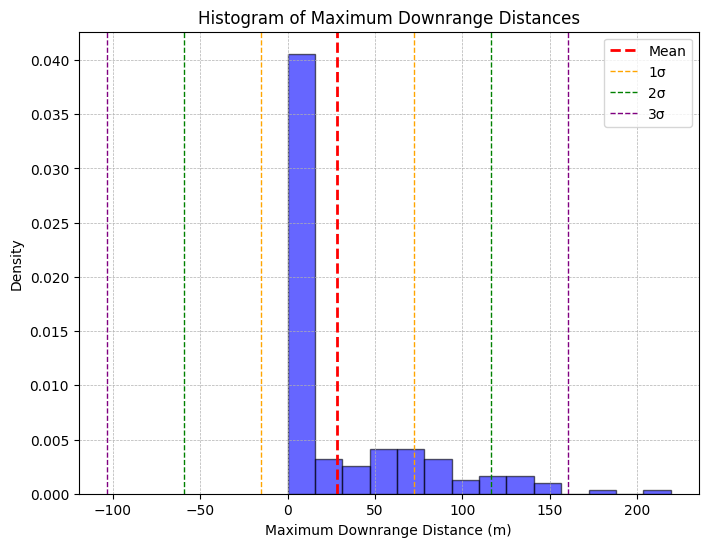

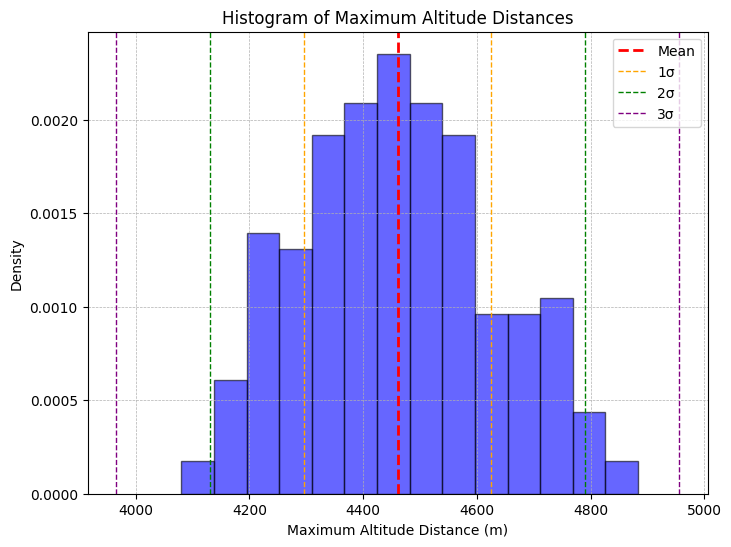

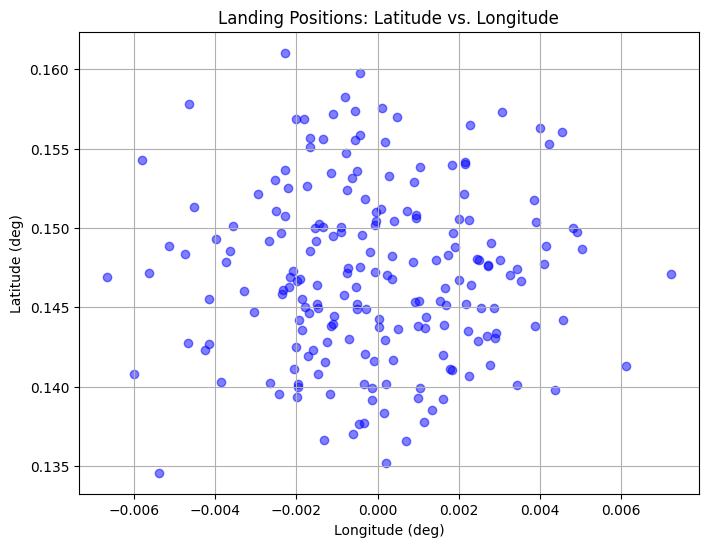

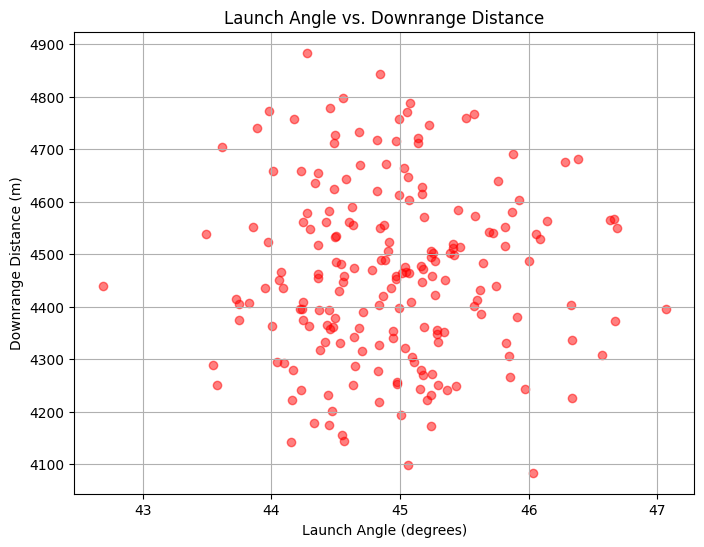

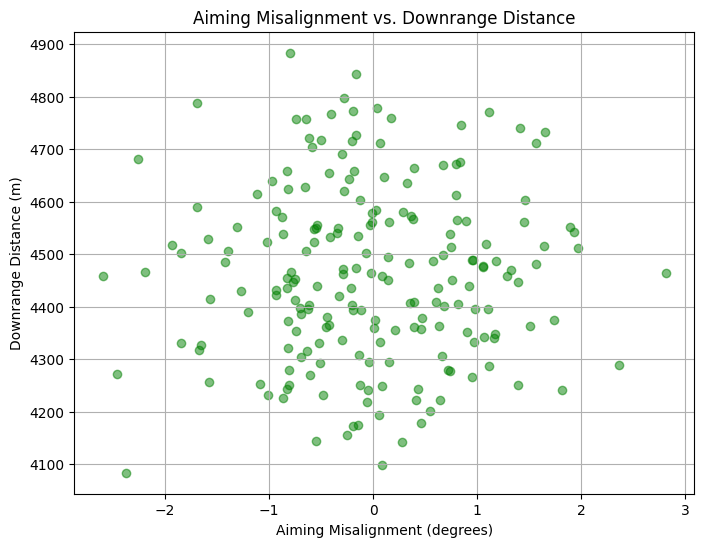

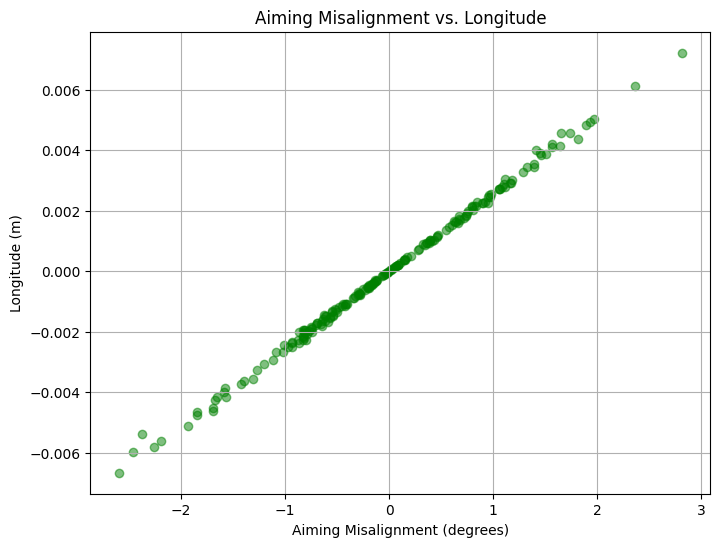

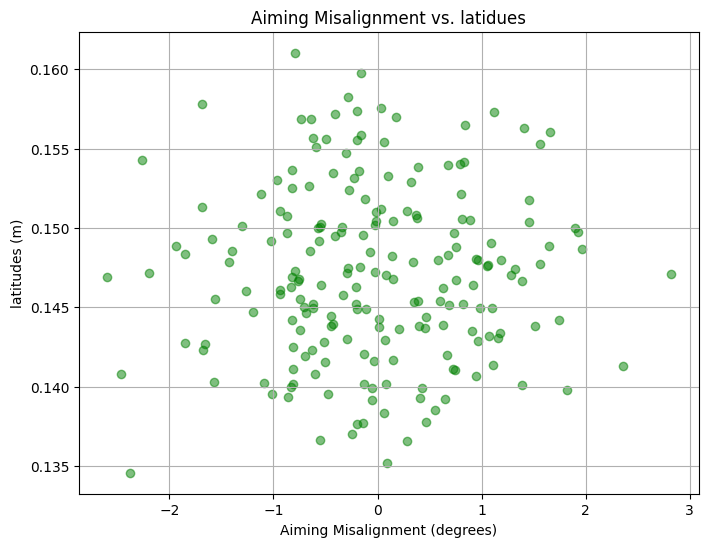

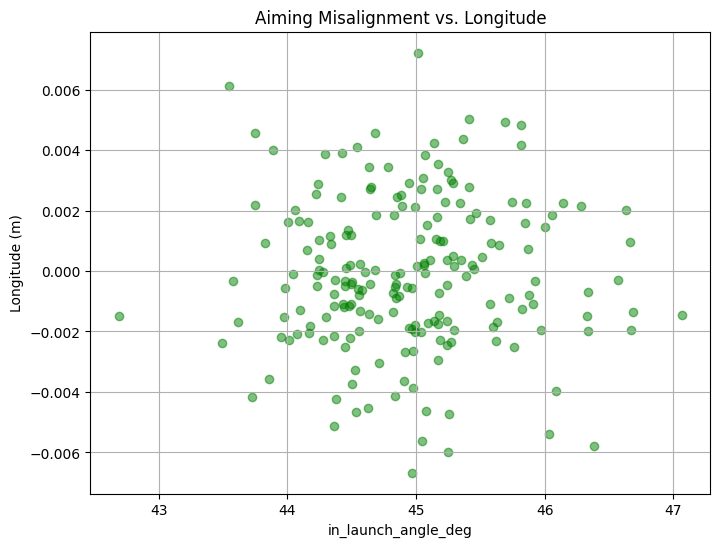

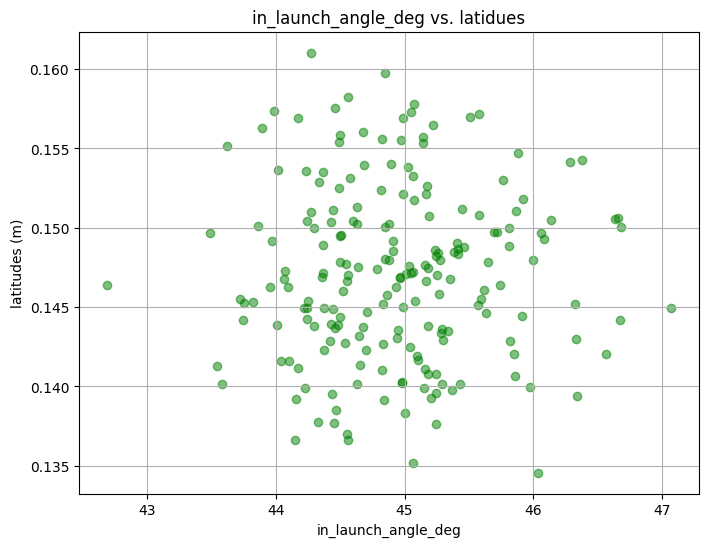

In [2]:

import numpy as np
from scipy.spatial.transform import Rotation as R

# import quaternion
import matplotlib.pyplot as plt
import math
# import transform3d as t3d



# Constants
moon_radius = 1737.4e3  # Moon's radius in meters
moon_gravity = 1.625  # Lunar gravitational acceleration in m/s²
num_simulations = 200  # Number of Monte Carlo runs
dt = .1  # Time step for numerical integration (in seconds)


#This function will create the initial conditions for the graph.
#


def initialize_quaternion(spin_rate_rps, spin_axis_misalignment):
    """
    Initialize the ball's orientation as a quaternion.

    Args:
        spin_rate_rps (float): Ball's spin rate in rotations per second.
        spin_axis_misalignment (float): Misalignment angle in radians.

    Returns:
        initial_quaternion (Rotation object): Quaternion representing initial orientation.
        angular_velocity (np.array): Angular velocity vector in radians per second.
    """
    # Define initial spin axis (aligned with z-axis)
    spin_axis = np.array([0, 0, 1])

    # Rotate the spin axis based on misalignment
    misalignment_quaternion = R.from_rotvec(spin_axis_misalignment * np.array([1, 0, 0]))  # Rotation about x-axis
    spin_axis = misalignment_quaternion.apply(spin_axis)  # Apply rotation

    # Convert spin rate from rotations per second to angular velocity (rad/s)
    angular_velocity = 2 * np.pi * spin_rate_rps * spin_axis  # ω = 2πf (rad/s)

    # Initial orientation quaternion (aligned with the Moon’s reference frame)
    initial_quaternion = R.from_quat([0, 0, 0, 1])  # Identity quaternion

    return initial_quaternion, angular_velocity

def plot_quaternion_over_time(time_array, quaternion_array):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(time_array, quaternion_array[:, 0], label='q0 (w)')
    ax.plot(time_array, quaternion_array[:, 1], label='q1 (x)')
    ax.plot(time_array, quaternion_array[:, 2], label='q2 (y)')
    ax.plot(time_array, quaternion_array[:, 3], label='q3 (z)')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Quaternion Components')
    ax.set_title('Quaternion Components Over Time')
    ax.legend()
    ax.grid(True)
    plt.show()

def plot_rpy_over_time(time_array, quaternion_array):
    rpy_array = R.from_quat(quaternion_array).as_euler('xyz', degrees=True)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(time_array, rpy_array[:, 0], label='Roll')
    ax.plot(time_array, rpy_array[:, 1], label='Pitch')
    ax.plot(time_array, rpy_array[:, 2], label='Yaw')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Angle (degrees)')
    ax.set_title('Roll, Pitch, and Yaw Over Time')
    ax.legend()
    ax.grid(True)
    plt.show()

def plot_yarnball(trajectory):
    downrange = compute_downrange(np.degrees(np.arcsin(trajectory[:, 2] / moon_radius)),
                                  np.degrees(np.arctan2(trajectory[:, 1], trajectory[:, 0])))
    altitude = trajectory[:, 2] - moon_radius
    plt.figure(figsize=(8, 6))
    plt.plot(downrange, altitude, 'b-', alpha=0.5)
    plt.xlabel('Downrange Distance (m)')
    plt.ylabel('Altitude (m)')
    plt.title('Altitude vs. Downrange Distance')
    plt.grid(True)
    plt.show()


def find_optimal_launch_angle():
    launch_angles = np.linspace(30, 60, 20)  # Sweep launch angles from 30 to 60 degrees
    downrange_distances = []
    for angle in launch_angles:
        _, traj = simulate_trajectory(85, np.radians(angle), 0)  # Set velocity = 85 m/s, no misalignment
        downrange_distances.append(compute_downrange(np.degrees(np.arcsin(traj[-1, 2] / moon_radius)),
                                                     np.degrees(np.arctan2(traj[-1, 1], traj[-1, 0]))))

    plt.figure(figsize=(8, 6))
    plt.plot(launch_angles, downrange_distances, 'ro-')
    plt.xlabel('Launch Angle (degrees)')
    plt.ylabel('Downrange Distance (m)')
    plt.title('Launch Angle vs. Maximum Downrange Distance')
    plt.grid(True)
    plt.show()


def sample_initial_conditions():

    velocity_normal_random = np.random.normal(85, 5/3)  # Mean = 85 m/s, std dev = 5 m/s
    launchangle_deg_normal_random = np.radians(np.random.normal(45, 2/3))  # Mean = 45°, std dev = 2°
    aiming_misalignment_deg_normal_random = np.radians(np.random.normal(0, 3/3))  # Mean = 0°, std dev = 3°
    spin_rate_rps_normal_random = np.random.normal(2000, 500/3) / 60  # Convert RPM to RPS (rotations per second)
    spinaxismisalignment_deg_normal_random = np.radians(np.random.normal(0, 3/3))  # Mean = 0°, std dev = 3°

    return  velocity_normal_random, launchangle_deg_normal_random, aiming_misalignment_deg_normal_random, spin_rate_rps_normal_random, spinaxismisalignment_deg_normal_random



def equations_of_motion(state):
    """
    Computes the equations of motion for the golf ball under lunar gravity.
    Assumes the Moon is a perfect sphere and gravity acts radially inward.
    Args:
        state (list): Current state vector [x, y, z, vx, vy, vz]
    Returns:
        list: Time derivatives [vx, vy, vz, ax, ay, az]
    """

    x, y, z, vx, vy, vz = state
    #I do not trust this. I think this is much more complicated that what this is
    #letting on

    r = np.sqrt(x**2 + y**2 + z**2)  # Distance from the Moon's center
    acc_x = -moon_gravity * (x / r)  # Radial acceleration components
    acc_y = -moon_gravity * (y / r)
    acc_z = -moon_gravity * (z / r)

    return [vx, vy, vz, acc_x, acc_y, acc_z]



def simulate_trajectory(velocity, launch_angle, aiming_misalignment):

    """
    Simulates the trajectory of the golf ball using numerical integration (Euler method).
    Assumptions:
        - No air resistance (since the Moon has no atmosphere)
        - No rolling or bouncing upon impact
        - The only force acting on the ball is lunar gravity
    Args:
        velocity (float): Initial velocity in m/s
        launch_angle (float): Initial launch angle in radians
        aiming_misalignment (float): Aiming deviation in radians
    Returns:
        np.array: Trajectory points (x, y, z) during flight
    """

    x, y, z = moon_radius, 0, 0  # Initial position at the Moon's equator

    #Check this as well, as this doesn't seem right

    vx = velocity * np.cos(launch_angle) * np.cos(aiming_misalignment)  # Initial velocity components
    vy = velocity * np.cos(launch_angle) * np.sin(aiming_misalignment)
    vz = velocity * np.sin(launch_angle)
    #outtest = (vx**2 + vy**2 + vz**2)**0.5
    #print(outtest)


    state = [x, y, z, vx, vy, vz]
    trajectory = []
    time_final = 0;

    while True:
        trajectory.append(state[:3])  # Store current position
        derivatives = equations_of_motion(state)  # Compute derivatives
        time_final += dt
        state = [s + d * dt for s, d in zip(state, derivatives)]  # Euler integration step

        # Stop simulation if ball reaches the Moon's surface (impact detected)
        if np.sqrt(state[0]**2 + state[1]**2 + state[2]**2) <= moon_radius:
            trajectory.append(state[:3])  # Store final position

            break

    return [np.array(trajectory), time_final]




def plot_histogram(data, title="Histogram", xlabel="Value", bins=80):


    mean = np.mean(data)
    std_dev = np.std(data)

    plt.figure(figsize=(8, 6))

    length = len(data)
    bin_whole = (round(length ** 0.5))

    plt.hist(data, bins=bin_whole, color='blue', alpha=0.6, edgecolor='black', density=True)

    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(mean - std_dev, color='orange', linestyle='dashed', linewidth=1, label='1σ')
    plt.axvline(mean + std_dev, color='orange', linestyle='dashed', linewidth=1)
    plt.axvline(mean - 2*std_dev, color='green', linestyle='dashed', linewidth=1, label='2σ')
    plt.axvline(mean + 2*std_dev, color='green', linestyle='dashed', linewidth=1)
    plt.axvline(mean - 3*std_dev, color='purple', linestyle='dashed', linewidth=1, label='3σ')
    plt.axvline(mean + 3*std_dev, color='purple', linestyle='dashed', linewidth=1)

    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.show()


def monte_carlo_simulation():
    """
    Runs a Monte Carlo simulation with randomly sampled initial conditions.
    Returns:
        np.array: Final landing positions of all simulated trajectories
    """
    in_vel_arr = [];
    in_launch_angle_deg =[];
    in_aiming_misalignment_deg =[];
    in_spin_rate_rps =[];
    in_spinaxismisalignment_deg =[];
    fin_flight_time = [];
    max_downrange_dis = [];
    max_alt_dis = [];



    results = []
    for _ in range(num_simulations):

#return  velocity_normal_random, launchangle_deg_normal_random, aiming_misalignment_deg_normal_random, spin_rate_rps_normal_random, spinaxismisalignment_deg_normal_random

        velocity_normal_random, launchangle_deg_normal_random, aiming_misalignment_deg_normal_random, spin_rate_rps_normal_random, spinaxismisalignment_deg_normal_random = sample_initial_conditions()  # Generate random initial conditions
        [traj, final_time] = simulate_trajectory(velocity_normal_random, launchangle_deg_normal_random, aiming_misalignment_deg_normal_random)  # Simulate trajectory
        results.append(traj[-1])  # Store final landing position

        in_vel_arr.append(velocity_normal_random)
        in_launch_angle_deg.append(np.degrees(launchangle_deg_normal_random))
        in_aiming_misalignment_deg.append(np.degrees(aiming_misalignment_deg_normal_random))
        in_spin_rate_rps.append(spin_rate_rps_normal_random)
        in_spinaxismisalignment_deg.append(np.degrees(spinaxismisalignment_deg_normal_random))
        fin_flight_time.append(final_time)
        max_downrange_dis.append(np.max(traj[:, 1]))
        max_alt_dis.append(np.max(traj[:, 2]))


    plot_histogram(in_vel_arr, title="Histogram of Initial Velocities", xlabel="Velocity (m/s)")
    plot_histogram(in_launch_angle_deg, title="Histogram of Initial Launch Angles", xlabel="Launch Angle (degrees)")
    plot_histogram(in_aiming_misalignment_deg, title="Histogram of Aiming Misalignments", xlabel="Aiming Misalignment (degrees)")
    plot_histogram(in_spin_rate_rps, title="Histogram of Spin Rates", xlabel="Spin Rate (RPM)")
    plot_histogram(in_spinaxismisalignment_deg, title="Histogram of Spin Axis Misalignments", xlabel="Spin Axis Misalignment (degrees)")
    plot_histogram(fin_flight_time, title="Histogram of Final Flight Times", xlabel="Final Flight Time (s)")
    plot_histogram(max_downrange_dis, title="Histogram of Maximum Downrange Distances", xlabel="Maximum Downrange Distance (m)")
    plot_histogram(max_alt_dis, title="Histogram of Maximum Altitude Distances", xlabel="Maximum Altitude Distance (m)")


    return [np.array(results), in_launch_angle_deg,in_aiming_misalignment_deg]

def compute_downrange(lat, lon):
    lat1, lon1 = np.radians(0), np.radians(0)  # Launch site at (0°, 0°)
    lat2, lon2 = np.radians(lat), np.radians(lon)  # Convert to radians

    delta_sigma = np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon2 - lon1))
    downrange_distance = moon_radius * delta_sigma  # Great-circle distance

    return downrange_distance


def plot_results(results, in_launch_angle_deg, in_aiming_misalignment_deg):
    """
    Plots the requested scatter plots.

    Args:
        results (np.array): Array of final landing positions (x, y, z)
        in_launch_angle_deg (list): Initial launch angles in degrees
        in_aiming_misalignment_deg (list): Aiming misalignments in degrees
        max_downrange_dis (list): Maximum downrange distances
    """

    # Convert x, y, z to latitude and longitude
    longitudes = np.degrees(np.arctan2(results[:, 1], results[:, 0]))  # Longitude
    latitudes = np.degrees(np.arcsin(results[:, 2] / moon_radius))  # Latitude

    down_dis = compute_downrange(latitudes, longitudes)


    # Plot 1: Latitude vs. Longitude
    plt.figure(figsize=(8, 6))
    plt.scatter(longitudes, latitudes, alpha=0.5, color='blue')
    plt.xlabel('Longitude (deg)')
    plt.ylabel('Latitude (deg)')
    plt.title('Landing Positions: Latitude vs. Longitude')
    plt.grid(True)
    plt.show()

    # Plot 2: Launch Angle vs. Downrange Distance
    plt.figure(figsize=(8, 6))
    plt.scatter(in_launch_angle_deg, down_dis, alpha=0.5, color='red')
    plt.xlabel('Launch Angle (degrees)')
    plt.ylabel('Downrange Distance (m)')
    plt.title('Launch Angle vs. Downrange Distance')
    plt.grid(True)
    plt.show()

    # Plot 3: Aiming Misalignment vs. Downrange Distance
    plt.figure(figsize=(8, 6))
    plt.scatter(in_aiming_misalignment_deg, down_dis, alpha=0.5, color='green')
    plt.xlabel('Aiming Misalignment (degrees)')
    plt.ylabel('Downrange Distance (m)')
    plt.title('Aiming Misalignment vs. Downrange Distance')
    plt.grid(True)
    plt.show()

      # Plot 4: Aiming Misalignment vs. Longitude
    plt.figure(figsize=(8, 6))
    plt.scatter(in_aiming_misalignment_deg, longitudes, alpha=0.5, color='green')
    plt.xlabel('Aiming Misalignment (degrees)')
    plt.ylabel('Longitude (m)')
    plt.title('Aiming Misalignment vs. Longitude')
    plt.grid(True)
    plt.show()

     # Plot 5: Aiming Misalignment vs. Longitude
    plt.figure(figsize=(8, 6))
    plt.scatter(in_aiming_misalignment_deg, latitudes, alpha=0.5, color='green')
    plt.xlabel('Aiming Misalignment (degrees)')
    plt.ylabel('latitudes (m)')
    plt.title('Aiming Misalignment vs. latidues')
    plt.grid(True)
    plt.show()

    # Plot 6: Aiming Misalignment vs. Longitude
    plt.figure(figsize=(8, 6))
    plt.scatter(in_launch_angle_deg, longitudes, alpha=0.5, color='green')
    plt.xlabel('in_launch_angle_deg')
    plt.ylabel('Longitude (m)')
    plt.title('Aiming Misalignment vs. Longitude')
    plt.grid(True)
    plt.show()

     # Plot 7: Aiming Misalignment vs. Longitude
    plt.figure(figsize=(8, 6))
    plt.scatter(in_launch_angle_deg, latitudes, alpha=0.5, color='green')
    plt.xlabel('in_launch_angle_deg')
    plt.ylabel('latitudes (m)')
    plt.title('in_launch_angle_deg vs. latidues')
    plt.grid(True)
    plt.show()




# return np.array(results, in_launch_angle_deg,in_aiming_misalignment_deg)
[results, in_launch_angle_deg, in_aiming_misalignment_deg] = monte_carlo_simulation()
# print(results)
plot_results(results, in_launch_angle_deg, in_aiming_misalignment_deg)




# # Run simulation and plot results
# results = monte_carlo_simulation()
# plot_results(results)